In [13]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, auc
import matplotlib.pyplot as plt
import seaborn as sns


# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | Tree status in year 1 post-fire. (0=alive, 1=dead)
| YrFireName                  | Year and name of the fire.                                    
| Times_burned                | The number of times this tree was burned                                           
| Species                     |  Symbol for species. First two letters of genus and first two letters of species, sometimes followed by a number                                                   
| Genus_species               |  Genus and species of tree                                     
| DBH_cm                      | Diameter at breast height rounded to nearest 0.1 cm (cm = centimeters). NA = not assessed.
| HT_m                        | Pre-fire tree height rounded to nearest 0.01 m (m=meters). NA = not assessed
| CR_pre                      | Pre-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.
| CR_post                     | Post-fire live crown ratio. Crown length divided by tree height (proportion rounded to nearest 0.01). NA = not assessed.

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [14]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')[['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species','DBH_cm', 'HT_m', 'CR_pre', 'CR_post']].dropna()

print(f"Observations left after removing NAs: {trees_dat.shape[0]}")

Observations left after removing NAs: 36509


/tmp/ipykernel_1463006/2508583498.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')[['yr1status', 'YrFireName', 'Times_burned', 'Species', 'Genus_species','DBH_cm', 'HT_m', 'CR_pre', 'CR_post']].dropna()


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [17]:
# Change data types of strings to numeric
for col in ['YrFireName', 'Species', 'Genus_species']:
    trees_dat[f"{col}"] = trees_dat[col].astype('category').cat.codes

print(trees_dat.dtypes)

yr1status        float64
YrFireName          int8
Times_burned       int64
Species             int8
Genus_species       int8
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [4]:
# Assign predictor and outcome variables 
X = trees_dat.loc[:, trees_dat.columns != 'yr1status']
Y = trees_dat[['yr1status']]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3. How many training/test observations do we have? Print your answer in the cell below. 

In [18]:
X_train_scaled_obs = X_train_scaled.shape[0]
X_test_scaled_obs = X_test_scaled.shape[0]

# Verify the training and testing set size
print("Training set observations:", X_train_scaled_obs )
print("Testing set observations:", X_test_scaled_obs)

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [19]:
model = LogisticRegression()
model.fit(X_train_scaled,y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

acc_train = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {acc_train:.4f}")

Training Accuracy: 0.9451


/opt/anaconda3/envs/ml-env/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

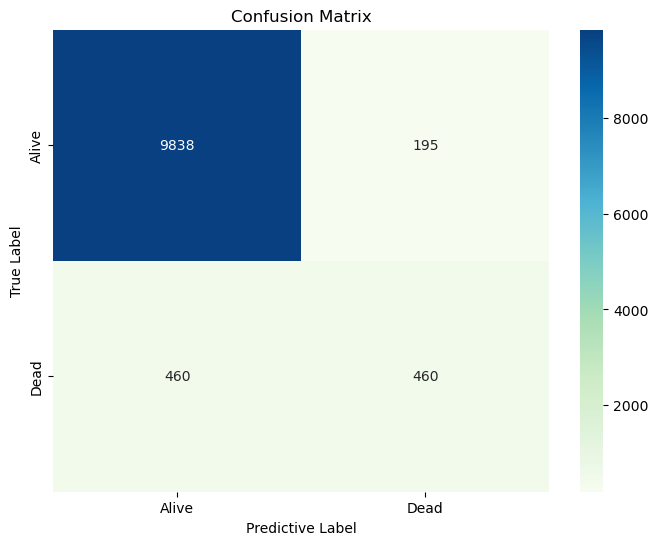


Model Performance Metrics :
Accuracy (from calculations): 0.940
Sensitivity (True positive rate): 0.500
Specificity (True negative rate): 0.981
Accuracy (from accuracy_score function): 0.9402


In [26]:
# Create confusion matrix using sns.heatmap

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'GnBu', # annot = annotate, fmt = format
               xticklabels = ['Alive', 'Dead'],
               yticklabels = ['Alive', 'Dead']) 
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predictive Label')

# calculate metrics
TP = cm[1,1] # true positive
TN = cm[0,0] # true negative
FP = cm[0,1] # false positive
FN = cm[1,0] # false negative

accuracy = (TP +TN)/ (TP + TN + FP + FN)
majority_baseline = max(np.mean(y_train), 1 - np.mean(y_train))
sensitivity = TP/(TP + FN)
specificity = TN / (TN + FP)
accuracy_test = accuracy_score(y_test, y_test_pred)

#Plot confusion matrix
plt.show()
print
 # print metrics
print(f"\nModel Performance Metrics :")
print(f"Accuracy (from calculations): {accuracy:.3f}")
print(f"Sensitivity (True positive rate): {sensitivity:.3f}")
print(f"Specificity (True negative rate): {specificity:.3f}")
print(f"Accuracy (from accuracy_score function): {accuracy_test:.4f}")

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

My model performed well with my unseen data, with a .94 accuracy. The true positive rate (trees that were predicted as alive and actually were alive) is .5, and my true negative rate (trees that were predicted to stay alive and actually did) is .98. There are 10,033 alive trees and 920 dead trees. This suggests a significant class imbalance, as many more trees are alive than burned. Our model favors trees that are alive because the majority did die. 

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

If we built a model that always predicts dead trees, then the model will still be quite accurate. That is because of the class imbalance and the fact that most of the trees burned, so predicting burned is gonna be correct over 90 percent of the time. Our logistic regression model is still more accurate, predicting burnt trees correctly 98 percent of the time.

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy:  0.9172

Dummy Confusion Matrix:


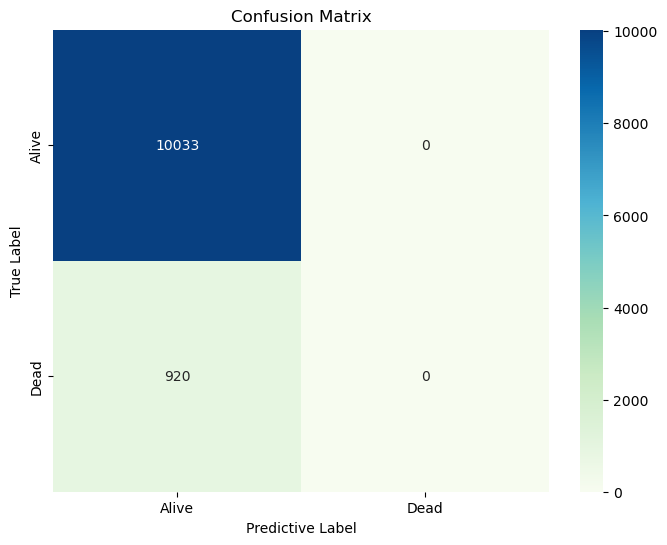

In [27]:
model_dummy = DummyClassifier(strategy = "most_frequent")
model_dummy.fit(X_train_scaled, y_train)


y_train_pred_dummy = model_dummy.predict(X_train_scaled)

y_test_pred_dummy = model_dummy.predict(X_test_scaled)

acc_train_dummy = accuracy_score(y_train, y_train_pred_dummy)


# Print accuracy and confusion matrix results
print(f"Dummy Accuracy:  {acc_train_dummy:.4f}")
print("\nDummy Confusion Matrix:")

cm_dummy = confusion_matrix(y_test, y_test_pred_dummy)

plt.figure(figsize = (8,6))
sns.heatmap(cm_dummy, annot = True, fmt = 'd', cmap = 'GnBu', # annot = annotate, fmt = format
               xticklabels = ['Alive', 'Dead'],
               yticklabels = ['Alive', 'Dead']) 
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predictive Label')


# calculate metrics
TP = cm[1,1] # true positive
TN = cm[0,0] # true negative
FP = cm[0,1] # false positive
FN = cm[1,0] # false negative

accuracy = (TP +TN)/ (TP + TN + FP + FN)
majority_baseline = max(np.mean(y_train), 1 - np.mean(y_train))
sensitivity = TP/(TP + FN)
specificity = TN / (TN + FP)
plt.show()
    

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [31]:
# Logistic classifier AUC
y_pred_prob = model.predict_proba(X_test_scaled)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob) # auc = area under the curve
    

print(f"Logistic AUC: {roc_auc}")

Logistic AUC: 0.9180671176422154


In [30]:
# Dummy classifier AUC
y_pred_prob_dummy = model_dummy.predict_proba(X_test_scaled)[:,1]
roc_auc_dummy = roc_auc_score(y_test, y_pred_prob_dummy) # auc = area under the curve
print(f"Dummy AUC: {roc_auc_dummy}")

Dummy AUC: 0.5


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

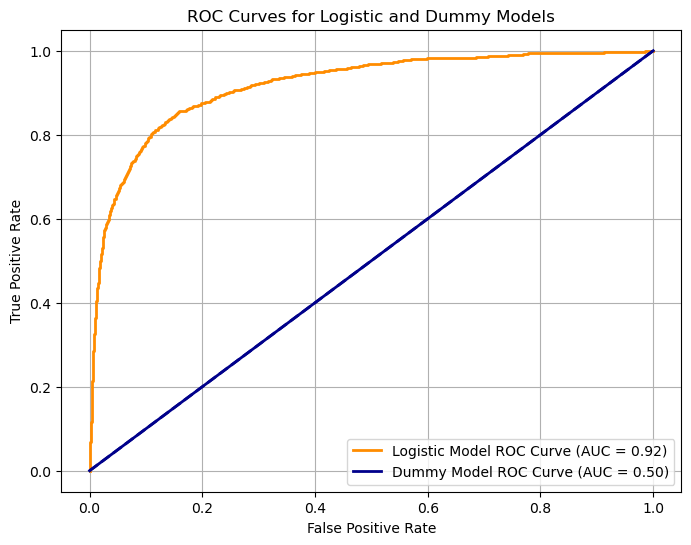

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve for logistic model
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Logistic Model ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Model')
plt.legend()
plt.grid(True)

fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_pred_prob_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)

# Plot ROC curve for dummy model
plt.plot(fpr_dummy, tpr_dummy, color='darkblue', lw=2, label=f"Dummy Model ROC Curve (AUC = {roc_auc_dummy:.2f})")
plt.legend()
plt.grid(True)
plt.title('ROC Curves for Logistic and Dummy Models')
plt.show()

How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The logistic model has an AUC of .92, while the dummy model's AUC is .50. This means that the logistic model is predicting probabilities much better than the dummy model, as the dummy model is no better than just guessing. The implications on evaluating classifiers soley based on accuracy of their predictions is that it does not show the full story. A model can be fairly accurate based on nothing more than a class inbalance. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [42]:
coefficients = model.coef_[0]

feature_names = X_train.columns

# Create a DataFrame to visualize feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})


# Sort the DataFrame by importance
importance_df = feature_importance_df.sort_values(by='Importance', key=abs, ascending=False)

print(feature_importance_df)


         Feature  Importance
0     YrFireName   -0.660497
1   Times_burned    0.000000
2        Species    0.541509
3  Genus_species   -0.067867
4         DBH_cm    0.421324
5           HT_m   -1.165414
6         CR_pre    0.123414
7        CR_post   -2.494974


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

When looking at the importance, we can determine what is most important by looking at the absolute values of the importance column. By far, the most important key factor is CR_post which is the post-fire live crown ratio. The next most important feature us HT_m which is pre-fire tree height. Conservationists should pay close attention to these two features in the trees they are looking at, as it is strongly influencing what trees live and die.